In [ ]:
#| default_exp graphtools
from diffusion_curvature.kernels import *
from diffusion_curvature.datasets import *
from fastcore.all import *
import numpy as np
from nbdev import show_doc

# Implementation (Graphtools)
> Curvature computations on any graphtools graph

This notebook implements diffusion curvature atop the popular Graphtools library (also maintained by the Krishnaswamy Lab). To compute the curvature of any graphtools graph, simply instantiate a `DiffusionCurvature` object with your choice of parameters, and pass the graphtools graph through as input.

What follows is a literate implementation, showing the steps of the algorithm applied to our old friend, the torus.

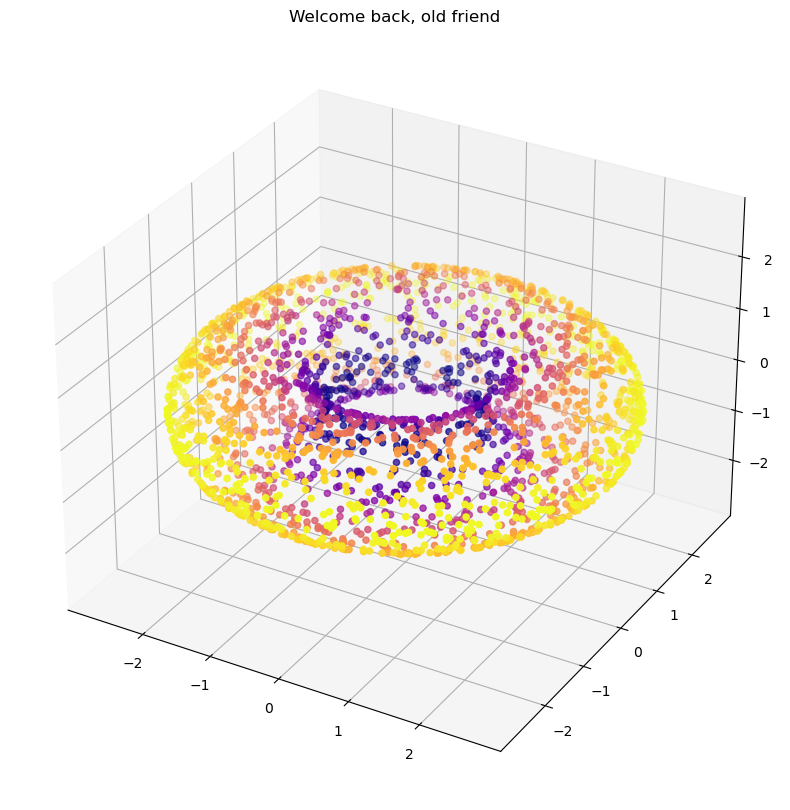

In [ ]:
from diffusion_curvature.datasets import torus
X_torus, torus_gaussian_curvature = torus(n=5000)
plot_3d(X_torus, torus_gaussian_curvature, title="Welcome back, old friend")

First we need to turn this into a graphtools graph. Fortunately, that's quite simple. We'll trust the graphtools defaults for now.

In [ ]:
import graphtools
G_torus = graphtools.Graph(X_torus, anisotropy=1,)
G_torus_landmarked = graphtools.Graph(X_torus, n_landmark=100)

Graphtools has some niceties, but also some limitations. It can, for instance, calculate the diffusion matrix, complete with anisotropic density normalization and automatic conversion into scipy's sparse matrix format. It can also compute the landmark operator - a compressed version of the diffusion matrix that diffusion only between a subset of "landmark" points within a dataset - enabling us to approximately power *huge* diffusion matrices. All of these features will be used!

In [ ]:
G_torus.P

<2526x2526 sparse matrix of type '<class 'numpy.float64'>'
	with 19286 stored elements in Compressed Sparse Row format>

## The Diffusion Curvature class
Following the convention of PyTorch modules, we separate the configuration/initialization of diffusion curvature from the operation.
First, you'll initialize the following class, then run the equivalent of a `fit_transform` function.

To better aid literate notebook-based development, the functions in the class will be attached via the fastcore `@patch` operator.
This allows us to debug them more easily.

In [ ]:
#|export
from fastcore.all import *
import graphtools
import numpy as np
import graphtools
import scipy.sparse
import math
import scipy
from scipy.stats import entropy
from diffusion_curvature.distances import *
import skdim
class DiffusionCurvature():
    def __init__(
    self,
    t:int, # Number of diffusion steps to use when measuring curvature. TODO: Heuristics
    distance_type = "PHATE",
    use_entropy:bool = False, # If true, uses KL Divergence instead of Wasserstein Distances. Faster, seems empirically as good, but less proven.
    **kwargs
    ):
        store_attr()

In [ ]:
DC = DiffusionCurvature(t=8)

First, we'll tackle the most computationally demanding step: powering the diffusion matrix.
Because graphtools defaults to scipy.sparse matrices, we can do this with the `**` operation, which doesn't (as in np arrays) perform elementwise operations. To be safe, we'll check if there's an np array and us `np.linalg.matrix_power` if so.

In [ ]:
#|export
@patch
def power_diffusion_matrix(self:DiffusionCurvature, G:graphtools.api.Graph, t=None):
        # Raises the diffusion matrix of G to t and stores the result in G.Pt
        if not t:
            t = self.t
        if type(G.P) == np.ndarray:
            G.Pt = np.linalg.matrix_power(G.P, t)
        elif type(G.P) == scipy.sparse.csr_matrix:
            if 'n_landmark' in G.get_params().keys():
                # the graph was built with landmarking. We'll power the diffusion matrix that way
                G.Pt = scipy.sparse.csr_matrix(
                    G.transitions @ np.linalg.matrix_power(G.landmark_op,t) @ G.transitions.T
                )
            else:
                G.Pt = G.P ** t
        else:
            raise NotImplementedError("Unknown Matrix Type")
        return G

Verifying... Does this indeed power the matrix?

In [ ]:
DC = DiffusionCurvature(t=8)
G_torus = DC.power_diffusion_matrix(G_torus)
def csr_allclose(a, b, rtol=1e-4, atol = 1e-4):
    c = np.abs(np.abs(a - b) - rtol * np.abs(b))
    return c.max() <= atol
assert csr_allclose(G_torus.Pt, G_torus.P @ G_torus.P @ G_torus.P@ G_torus.P@ G_torus.P@ G_torus.P@ G_torus.P@ G_torus.P)

In [ ]:
%%time
G_torus = DC.power_diffusion_matrix(G_torus,t=20)

CPU times: user 636 ms, sys: 0 ns, total: 636 ms
Wall time: 635 ms


We'll use this powered matrix to compute the manifold distances. The implementation of the distance functions can be found in the "Manifold Distances" notebook. Here, we just call them according to the class config.

In [ ]:
#|export
@patch
def distances(self:DiffusionCurvature, G):
        if self.distance_type == "PHATE":
            G = phate_distances(G)
        else:
           raise NotImplementedError(f"No distance with name {self.distance_type}")
        return G

In [ ]:
G_torus = DC.distances(G_torus)

To check that all has gone according to plan, here's an image of the torus with the distances superimposed. The scale of distances changes with the power of $P^t$.

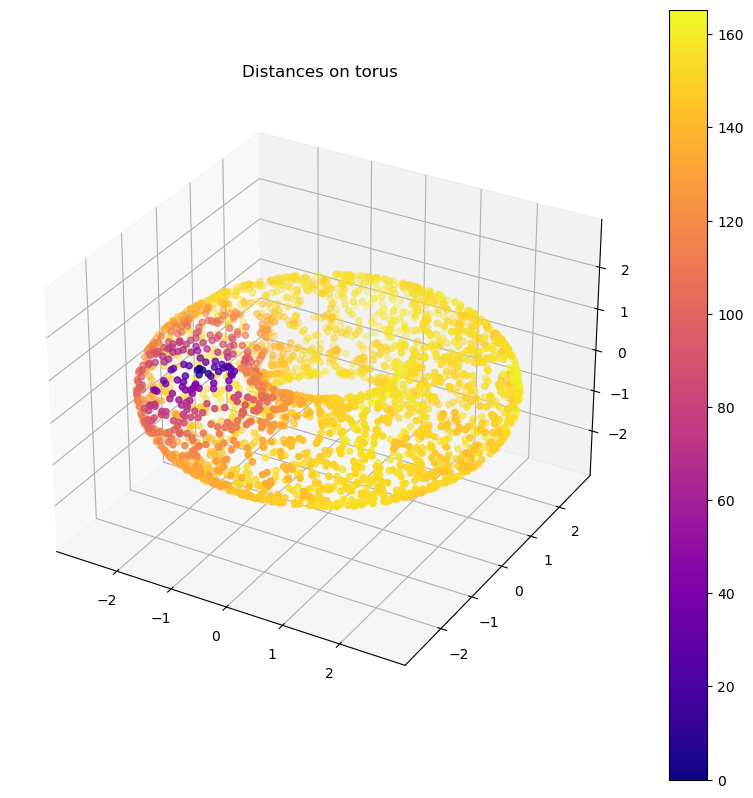

In [ ]:
plot_3d(X_torus,G_torus.D[3], "Distances on torus", colorbar=True)

## The Wasserstein Diffusion Curvature
This has two components: computing the spread of diffusion, and computing a "flattened facsimile" of the graph. 

For the second, we presently give a naive implementation that presumes the dimensionality is known and constructs random noise of the same dimension and size.

In [ ]:
#|export
@patch
def wasserstein_spread_of_diffusion(self:DiffusionCurvature, G:graphtools.graphs.DataGraph, idx = None):
        """
        Returns how "spread out" each diffusion is, with wasserstein distance"
        Presumes that the manifold distances have been separately calculated
        If idx is passed, only computes wsd at that index
        """
        assert G.Pt is not None
        assert G.D is not None
        # G.P is our distribution on each node. We compute the sum of the distances each bit of "diffusion mass" has to be carried 
        # back to the center
        # Convert to numpy array;
        if type(G.Pt) == np.ndarray:
            Pt = G.Pt
        else:
            Pt = G.Pt.toarray()
        if idx is None:
            return np.sum(G.D * Pt, axis=1)
        else:
            return np.sum(G.D[idx]* Pt[idx])

In [ ]:
DC.wasserstein_spread_of_diffusion(G_torus)

array([44.02303658, 39.94026923, 46.38643638, ..., 38.48505934,
       44.2566721 , 44.51556675])

To create a flattened graph as similar as possible to the original, we need to use the same graphtools parameters as used to initialize `G`. Most of these, fortunately, are easily accessible. Some - like the type of graph - require reverse engineering.

In [ ]:
G_exact = graphtools.Graph(X_torus, graphtype='exact')
# G_mnn = graphtools.Graph(X_torus, graphtype='mnn')
G_knn = graphtools.Graph(X_torus, graphtype='knn')

In [ ]:
#|export
def get_graph_type(G):
    tt = str(type(G)).split('.')[-1][:3].lower()
    # TODO: Support for MNN graphs
    if tt == 'mnn': raise NotImplementedError("MNN Graphs require manual indices. These are not yet supported by our graph flattener.")
    if tt in ['knn']: return tt
    else: return 'exact'

In [ ]:
test_eq('knn', get_graph_type(G_knn))
test_eq('exact', get_graph_type(G_exact))

The other parameters are either stored in the

In [ ]:
G_torus.get_params()

{'n_pca': None,
 'random_state': None,
 'kernel_symm': '+',
 'theta': None,
 'anisotropy': 1,
 'knn': 5,
 'decay': 40,
 'bandwidth': None,
 'bandwidth_scale': 1.0,
 'knn_max': None,
 'distance': 'euclidean',
 'thresh': 0.0001,
 'n_jobs': -1,
 'verbose': False}

function, or can be safely set to None.

In [ ]:
#|export
@patch
def flattened_facsimile_of_graph(self:DiffusionCurvature, G:graphtools.graphs.DataGraph, dimension):
        """
        Constructs a flat graph, hewn from uniform random noise of the supplied dimension.
        Calculates the powered diffusion matrix on this graph.
        """
        noise = np.concatenate([np.zeros((1,dimension)), 2*np.random.rand(G.K.shape[0]-1,dimension)-1])
        # Build a graph out of the noise, with all of the same kernel settings as our first graph
        # NOTE: The graph building settings must be scale invariant! 
        params = G.get_params()
        needed_keys = ['data', 'n_pca', 'knn', 'decay', 'bandwidth', 'bandwidth_scale', 
                    'knn_max', 'anisotropy', 'beta', 'adaptive_k', 'n_landmark', 'n_landmark', 
                    'n_svd', 'n_jobs']
        found_keys = {} # TODO: Likely a more elegant way to do this
        for nk in needed_keys:
            if nk in params.keys():
                found_keys[nk] = params[nk]
            else:
                found_keys[nk] = None
        
        G_flat = graphtools.Graph(
            data = noise,
            n_pca = found_keys['n_pca'],
            knn = found_keys['knn'],
            decay = found_keys['decay'],
            bandwidth = found_keys['bandwidth'],
            bandwidth_scale = found_keys['bandwidth_scale'],
            knn_max = found_keys['knn_max'],
            anisotropy = found_keys['anisotropy'],
            beta = found_keys['beta'],
            adaptive_k = found_keys['adaptive_k'],
            n_landmark = found_keys['n_landmark'],
            n_svd = found_keys['n_svd'],
            n_jobs = found_keys['n_jobs'],
            graphtype = get_graph_type(G),
        )
        G_flat = self.power_diffusion_matrix(G_flat, t = self.t)
        # TODO: This is a tad wasteful. We only need the center diffusion powered.
        return G_flat

In [ ]:
G_flattened = DC.flattened_facsimile_of_graph(G_torus,dimension=2)

This is an alternate measurement of a diffusion's "spread". 

In [ ]:
#|export
@patch
def entropy_of_diffusion(self:DiffusionCurvature, G:graphtools.graphs.DataGraph, idx=None):
        """
        Returns the pointwise entropy of diffusion from the powered diffusion matrix in the inpiut 
        """
        assert G.Pt is not None
        # TODO: Entropy may be compatible with scipy.sparse matrices
        if type(G.Pt) == np.ndarray:
            Pt = G.Pt
        else:
            Pt = G.Pt.toarray()
        if idx is None:
            return entropy(Pt, axis=1)
        else:
            return entropy(Pt[idx])

At last, we can assemble all of this into a curvature definition.
The steps are:
1. Precompute $P^t$ and $D$.
2. Estimate the local dimension of each point, unless a dimension is given, in which case we assume it is the global dimension.
3. Construct a flattened graph for each of the distinct local dimensions. Compute the spread of the diffusion there and on the actual data. Take the difference. Huzzah - It's diffusion curvature.

In [ ]:
#|export
@patch
def curvature(self:DiffusionCurvature, 
    G:graphtools.graphs.DataGraph, # A graphtools graph to compute the curvature of
    t=None,  # The number of steps within the random walks. Corresponds to how local/global the curvature estimate is.
    dimension:int = None,  # If supplied, the global manifold dimension. If not supplied, estimates the local dimension of each point.
    ):
    """
    Computes diffusion curvature of input graph. Stores it in G.ks
    """
    if t is None:
        t = self.t
    G = self.power_diffusion_matrix(G,t)
    G = self.distances(G)
    spreads_on_manifold = self.wasserstein_spread_of_diffusion(G) if not self.use_entropy else self.entropy_of_diffusion(G)
    # Create flattened version of manifold and compute stuff
    if dimension is not None:
        # dimension was supplied as an int. There's a single global dimension. Our life is easy.
        G_flat = self.flattened_facsimile_of_graph(G, dimension=dimension)
        G_flat = self.power_diffusion_matrix(G_flat,t)
        G_flat = self.distances(G_flat)
        spreads_on_flat = self.wasserstein_spread_of_diffusion(G_flat, idx=0) if not self.use_entropy else self.entropy_of_diffusion(G, idx=0)
        G.ks = 1 - (spreads_on_manifold/spreads_on_flat)
    else:
        # compute local dimension of each point, 
        # TODO: Currently this requires underlying points.
        print("estimating local dimension of each point... may take a while")
        ldims = skdim.id.DANCo().fit_pw(G.data,
                            n_neighbors = 100,
                            n_jobs = 1)
        dims_per_point = np.round(ldims.dimension_pw_)
        unique_dims = set(dims_per_point)
        unique_flats = {}
        for d in unique_dims:
            G_flat = self.flattened_facsimile_of_graph(G, dimension=d)
            G_flat = self.power_diffusion_matrix(G_flat,t)
            G_flat = self.distances(G_flat)
            unique_flats[d] = self.wasserstein_spread_of_diffusion(G_flat, idx=0) if not self.use_entropy else self.entropy_of_diffusion(G, idx=0)
        divided_pts = np.array([spreads_on_manifold/unique_flats[localdim] for localdim in dims_per_point])
        G.ks = 1 - divided_pts
    return G

In [ ]:
G_torus.D[0]

array([  0.        , 144.28032644, 157.45605873, ..., 155.44252822,
       162.36587856,  48.85831151])

In [ ]:
G_torus = DC.curvature(G_torus,dimension=2)

In [ ]:
#|export
from diffusion_curvature.kernels import plot_3d
def plot_manifold_curvature(G, title = None):
    X = G.data
    ks = G.ks
    plot_3d(X, ks, colorbar=True, title=title)

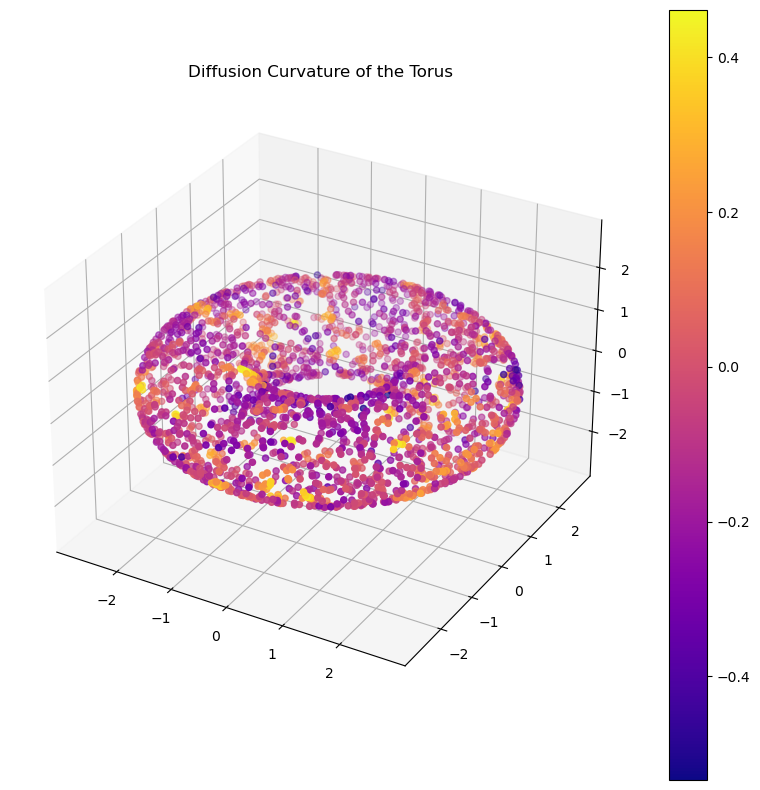

In [ ]:
plot_manifold_curvature(G_torus,"Diffusion Curvature of the Torus")

# Use on Data
To compute the wasserstein diffusion curvature of the data, first put the data into your `ManifoldGraph` object. Supply the dimension of the data, if you know it. Also select the parameters for creating an affinity matrix: the kernel type, the number of neighbors to use, and the degree of anisotropic density normalization.

If you're unsure what value to put for any of these, leave it blank. We'll use heuristics to find a good value for t and use our own dimension fitting to find a good value for that.

Alternately, if already have a graph (A), or any other piece of the puzzle, just supply it as an argument when initializing the `ManifoldGraph` class.

In [ ]:
G_torus = graphtools.Graph(X_torus, anisotropy=1, knn=30)

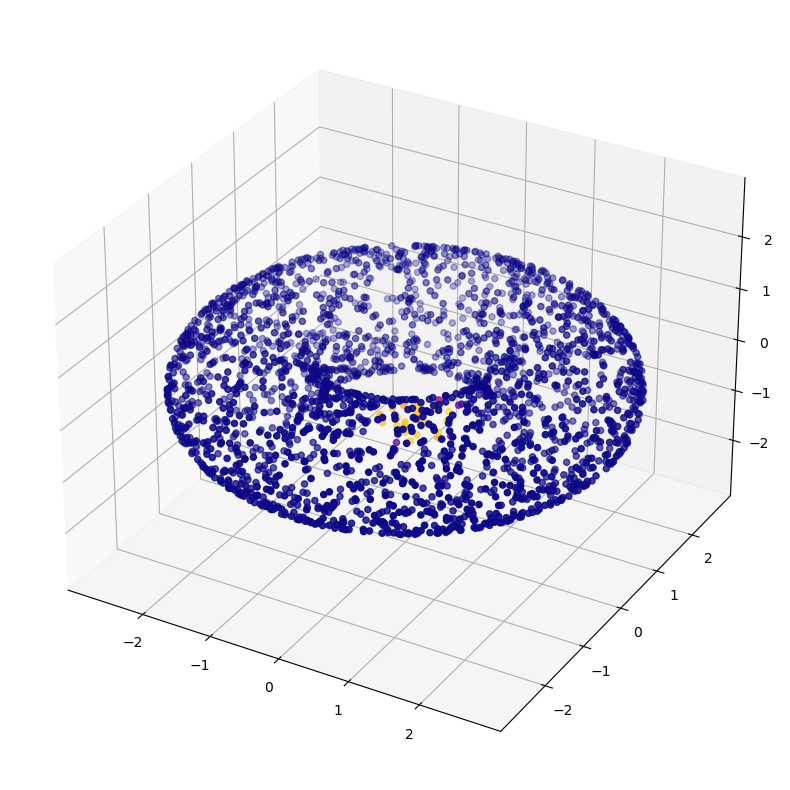

In [ ]:
plot_3d(X_torus, G_torus.P[0].toarray())

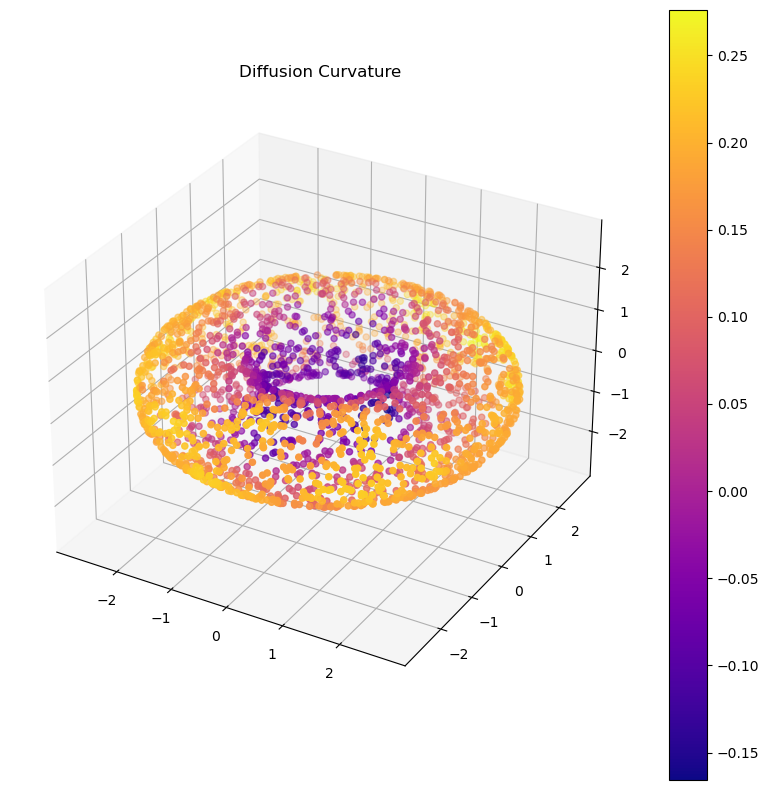

In [ ]:
DC = DiffusionCurvature(t=12)
G_torus = DC.curvature(G = G_torus, dimension=2)
plot_manifold_curvature(G_torus, title="Diffusion Curvature")

In [ ]:
%%time
G_torus = DC.power_diffusion_matrix(G_torus, t=20)

CPU times: user 21.1 s, sys: 5.94 ms, total: 21.1 s
Wall time: 21.1 s


In [ ]:
G_torus.P.shape

(2526, 2526)